# Classifying CIFAR-10 using a single fully connected layer 
In this notebook, we will see how to learn a classifier with a single linear layer by minimising the cross-entropy loss. The training set for CIFAR-10 contatins 50,000 3x32x32 images, each image belonging to one of the 10 classes. We will also see how to use L2 reqularization and train the classifier using vanila gradient descent.

### 1. Data Loading: Let us load the training and the test data and check the size of the tensors. Let us also display the first few images from the training set.

In [1]:
-- load trainin images
tr_x = torch.load('cifar10/tr_data.bin')
-- load trainin labels 
tr_y = torch.load('cifar10/tr_labels.bin'):double() + 1
-- load test images
te_x = torch.load('cifar10/te_data.bin')
-- load test labels 
te_y = torch.load('cifar10/te_labels.bin'):double() + 1


-- tr_x = tr_x[{{1,20},{},{},{}}]
-- te_x = tr_x[{{1,20},{},{},{}}]
-- tr_y = tr_y[{{1,20}}]
-- te_y = tr_y[{{1,20}}]
print(tr_x:size())
print(tr_y:size())

 50000
     3
    32
    32
[torch.LongStorage of size 4]

 50000
[torch.LongStorage of size 1]



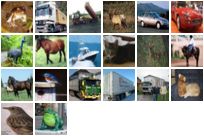

In [2]:
-- display the first 36 training set images
require 'image';
itorch.image(tr_x[{{1,20},{},{},{}}])

### 2. Data Preprocessing: We compute the mean and standard deviation 'images' and then subtract and divide by the same respectively (like AlexNet).  We also visualize them.

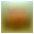

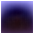

In [3]:
x_mean = torch.mean(tr_x:float(), 1)
x_std = torch.std(tr_x:float(), 1)
itorch.image(x_mean)
itorch.image(x_std)

### 3. Define the linear layer class. We implement the forward and the backward functions. Note that thus class never updates its own weights, it simply computes the gradients for weights.

In [4]:
local Linear = torch.class("Linear")

function Linear:__init()
    self.output = nil
    self.gradInput = torch.zeros(10):float()
    self.W = 2*(torch.rand(10, 3*32*32):float()-0.5) 
    self.b = 2*(torch.rand(10)-0.5):float()
    self.gradW = torch.zeros(10, 3*32*32):float()
    self.gradb = torch.zeros(10):float()
end

-- Wx + b
function Linear:forward(xi)
    self.output = self.W * xi + self.b
    return self.output
end

-- dL/dW = dL/do * do/dW (note that we also account for L2 weight reqularization)
function Linear:backward(xi, dl_do)
    self.gradW:copy((xi:reshape(3*32*32,1) * dl_do:reshape(1,10)):t() - lambda * self.W)
    self.gradb:copy(dl_do)
end

-- helper function to remember best model
function Linear:copy(model)
    self.W:copy(model.W)
    self.b:copy(model.b)
end

### 3. Define the Cross Entropy Error class. We implement the forward and the backward functions. The forward function computes the loss and the backward function computes the gradient of the loss with respect to output.

In [5]:
local CEC = torch.class("CEC")

function CEC:__init()
    self.output = nil
    self.gradInput = torch.zeros(10):float()
end

-- L_i = -log(e^yi/sum_j(e^yj)) + lambda*||W||^2
function CEC:forward(op, ti, model, lambda)
    op = op:exp()
    op = op/(op:sum())
    local lossL2 = model.W:clone()
    lossL2 = lossL2:cmul(lossL2):sum()
    self.output = -math.log(op[ti]) + lambda * lossL2
    return self.output
end

-- dL_i/do = 1 - op
function CEC:backward(op, ti)
    self.gradInput:fill(0)
    self.gradInput[ti] = 1
    self.gradInput = self.gradInput - op
    return self.gradInput
end

### 4. Define the vanilla gradient descent function.

In [6]:
function gradient_descent(model, lr)
    w_scale = torch.norm(model.W:view(model.W:nElement()), 2, 1)
    update_scale = torch.norm(lr * model.gradW:view(model.gradW:nElement()), 2, 1)
    model.W = model.W + lr * model.gradW
    model.b = model.b + lr * model.gradb
    print(update_scale/w_scale) -- Want ~1e-3
end

### 5. Some helper functions.

In [7]:
function get_xi(data_x, idx)   
    xi = (data_x[idx]:float() - x_mean)
    xi = xi:cdiv(x_std)
    xi = xi:reshape(3*32*32)
    return xi
end

function mod(a, b)
    return a - math.floor(a/b)*b
end

### 6. A function to count the number of incorrect classifications. Note that since we can not afford to calcuate the errors on the entire set, we do this on a random sub-set.

In [8]:
require 'math'
randomIdx = {}
for i = 1,100 do
    table.insert(randomIdx, math.random(10000))
end
function evaluate(model, data_x, data_y) 
    errors = 0
    for i = 1,#randomIdx do
        idx = randomIdx[i]
        xi = get_xi(data_x, idx)
        op = model:forward(xi)
        _, op_label = torch.max(op, 1)
        ti = data_y[idx]
        if ti ~= op_label[1] then
            errors = errors + 1
        end
    end
    return errors/#randomIdx
end

### 7. Define the main function that loops over the data points, calcuates the loss and upates the parameters of the model.

In [9]:
function train_and_test_loop(no_iterations, lr, lambda)
    for i = 0, no_iterations do
        -- trainin input and target
        idx = shuffle[mod(i, tr_x:size(1)) + 1]
        xi = get_xi(tr_x, idx) 
        ti = tr_y[idx]
        
        -- Train
        -- do forward of the model, compute loss
        -- and then do backward of the model
        op = model:forward(xi)
        loss_tr = criterion:forward(op, ti, model, lambda)
        dl_do = criterion:backward(op, ti)
        model:backward(xi, dl_do)
        epochloss_tr = epochloss_tr + loss_tr

        -- Test
        idx = shuffle_te[mod(i, te_x:size(1)) + 1] 
        xi = get_xi(te_x, idx) 
        ti = te_y[idx]
        -- Compute loss
        op = model:forward(xi) 
        loss_te = criterion:forward(op, ti, model, lambda)
        epochloss_te = epochloss_te + loss_te

        -- udapte model weights
        gradient_descent(model, lr)

        if mod(i, 500) == 0 then
            err = evaluate(model, tr_x, tr_y)
            print('iter: '..i.. ', accuracy: '..(1 - err)*100 ..'%  Loss: '..epochloss_tr/100)
            epochloss_te = 0
            epochloss_tr = 0
           
            if (err < besterr) then
                besterr = err
                bestmodel:copy(model)
                print(' -- best accuracy achieved: '.. (1- besterr)*100 ..'%')
            end
            collectgarbage()
        end
    end
    return (1 - besterr)*100 -- Accuracy
end

### 8. Let us now finally call our training function. Note the range in which we initialize the weights, and the various choices we make for the hyperparameters such as learning rate, etc.

In [11]:
function init_model()
    -- define the model and criterion
    model = Linear.new(0.001)
    criterion = CEC.new()
    bestmodel = Linear.new(0)
end

-- run it
lr = 1e-3
lambda = 1e-7

for i = 1, 20 do
    init_model()
    lr = math.pow(10, torch.uniform(-6.0, -4.0))
    lambda = math.pow(10, torch.uniform(-3, 1))
    best_acc = train_and_test_loop(2000, lr, lambda)
    print(string.format("Try %d/%d Best val accuracy: %d, lr: %f, lambda: %f",i, 100, best_acc, lr, lambda))
end

Try 1/100 Best val accuracy: 35, lr: 0.000055, lambda: 0.002026	


Try 2/100 Best val accuracy: 28, lr: 0.000001, lambda: 1.994656	


Try 3/100 Best val accuracy: 32, lr: 0.000003, lambda: 0.483409	


Try 4/100 Best val accuracy: 37, lr: 0.000032, lambda: 1.981563	


Try 5/100 Best val accuracy: 27, lr: 0.000003, lambda: 0.004578	


Try 6/100 Best val accuracy: 28, lr: 0.000004, lambda: 0.082862	


Try 7/100 Best val accuracy: 34, lr: 0.000020, lambda: 0.003083	


Try 8/100 Best val accuracy: 28, lr: 0.000054, lambda: 0.064499	


Try 9/100 Best val accuracy: 31, lr: 0.000003, lambda: 0.004361	


Try 10/100 Best val accuracy: 32, lr: 0.000004, lambda: 0.001610	


Try 11/100 Best val accuracy: 31, lr: 0.000006, lambda: 0.300821	


Try 12/100 Best val accuracy: 26, lr: 0.000004, lambda: 8.775347	


Try 13/100 Best val accuracy: 34, lr: 0.000064, lambda: 0.236847	


Try 14/100 Best val accuracy: 28, lr: 0.000013, lambda: 0.047457	


Try 15/100 Best val accuracy: 28, lr: 0.000004, lambda: 0.041229	


Try 16/100 Best val accuracy: 23, lr: 0.000001, lambda: 0.122963	


Try 17/100 Best val accuracy: 29, lr: 0.000077, lambda: 1.570716	


Try 18/100 Best val accuracy: 31, lr: 0.000008, lambda: 0.002189	


Try 19/100 Best val accuracy: 34, lr: 0.000036, lambda: 0.603766	


Try 20/100 Best val accuracy: 27, lr: 0.000003, lambda: 1.732092	


### 9. Plot the training and the test Loss curve times at every 1000 iterations.

In [ ]:
Plot = require 'itorch.Plot'
xaxis = {}
for i=1, #epochlosses_tr do
    table.insert(xaxis, i)
end
plot = Plot():line(xaxis, epochlosses_tr, 'red', 'train')
plot:line(xaxis, epochlosses_te, 'green', 'test'):legend(true):title('Train and Test Loss')
plot:draw():save('out.html')

### 10. As we discussed in the class, let us try to visualize the the rows of the Weight matrix.

In [ ]:
Ws = {}
for i = 1, 10 do
    table.insert(Ws, bestmodel.W[i]:reshape(3,32,32))
end
itorch.image(Ws)

### 11. Let us now try to train with slightly different hyperpameters and see what happens  and again vizualize the training and test errors over time. Let us also vizualize the rows of the Weight matrix.

In [ ]:
besterr = 1e10

-- for plotting losses later on
epochloss_te = 0
epochloss_tr = 0
epochlosses_tr = {}
epochlosses_te = {}

-- define the model and criterion
model = Linear.new(0.0001)
criterion = CEC.new()
bestmodel = Linear.new(0)

-- run it
lr = 0.0001
lambda = 0.0
train_and_test_loop(100000, lr, lambda)

Plot = require 'itorch.Plot'
xaxis = {}
for i=1, #epochlosses_tr do
    table.insert(xaxis, i)
end

In [ ]:
plot = Plot():line(xaxis, epochlosses_tr, 'red', 'train')
plot:line(xaxis, epochlosses_te, 'green', 'test'):legend(true):title('Train and Test Loss')
plot:draw():save('out.html')

In [ ]:
Ws = {}
for i = 1, 10 do
    table.insert(Ws, bestmodel.W[i]:reshape(3,32,32))
end
itorch.image(Ws)

### 12. Let us again try to train again with slightly different hyperpameters and see what happens (we add weight requlaization with lambda = 0.1). We also change the weight initiliation range back to 0.01  and again vizualize the training and test errors over time. Let us also vizualize the rows of the Weight matrix.

In [ ]:
besterr = 1e10

-- for plotting losses later on
epochloss_te = 0
epochloss_tr = 0
epochlosses_tr = {}
epochlosses_te = {}

-- define the model and criterion
model = Linear.new(0.01)
criterion = CEC.new()
bestmodel = Linear.new(0)

-- run it
lr = 0.0001
lambda = 0.1
train_and_test_loop(100000, lr, lambda)

In [ ]:
Plot = require 'itorch.Plot'
xaxis = {}
for i=1, #epochlosses_tr do
    table.insert(xaxis, i)
end
plot = Plot():line(xaxis, epochlosses_tr, 'red', 'train')
plot:line(xaxis, epochlosses_te, 'green', 'test'):legend(true):title('Train and Test Loss')
plot:draw():save('out.html')

In [ ]:
Ws = {}
for i = 1, 10 do
    table.insert(Ws, bestmodel.W[i]:reshape(3,32,32))
end
itorch.image(Ws)

In [18]:
x = torch.rand(9,9):fill(1)

In [22]:
torch.norm(x:view(x:nElement()),2,1)

 9
[torch.DoubleTensor of size 1]



In [21]:
x

 1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1
[torch.DoubleTensor of size 9x9]

